# Radial Basis Function (RBF) Network for 2D Regression

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
np.random.seed(42)

### 2D Synthetic Data Generation (Mixture of Gaussians)

In [ ]:
def mog2D_gen(Npatterns=10000, visualize=True):
    """
    Generates a 2D Mixture of Gaussians synthetic dataset

    Parameters:
    - Npatterns: Number of data points (should be a perfect square)
    - visualize: Whether to plot the generated data

    Returns:
    - X: Input features (Npatterns x 2)
    - y: Target values (Npatterns x 1)
    - XX1, XX2: Meshgrid coordinates (for visualization)
    - YY: Meshgrid target values (for visualization)
    """
    n = int(np.sqrt(Npatterns))
    x1 = np.linspace(-10, 10, n)
    x2 = np.linspace(-10, 10, n)
    XX1, XX2 = np.meshgrid(x1, x2)

    # Define parameters for three 2D Gaussian kernels
    centre1, centre2, centre3 = -8, -1, 7
    ampl1, ampl2, ampl3 = 3, -5, 9
    epsilon = 0.3

    # Compute each 2D kernel component
    k1 = ampl1 * np.exp(-((XX1 - centre1) * epsilon)**2) * np.exp(-((XX2 - centre1) * epsilon)**2)
    k2 = ampl2 * np.exp(-((XX1 - centre2) * epsilon)**2) * np.exp(-((XX2 - centre2) * epsilon)**2)
    k3 = ampl3 * np.exp(-((XX1 - centre3) * epsilon)**2) * np.exp(-((XX2 - centre3) * epsilon)**2)

    # Combine kernels to form target output
    YY = k1 + k2 + k3

    # Flatten for training data
    X = np.column_stack([XX1.ravel(), XX2.ravel()])
    y = YY.ravel()

    if visualize:
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(XX1, XX2, YY, cmap='viridis')
        fig.colorbar(surf)
        ax.set_title('2D Mixture of Gaussians Synthetic Dataset', fontsize=14)
        ax.set_xlabel('X1', fontsize=12)
        ax.set_ylabel('X2', fontsize=12)
        ax.set_zlabel('y', fontsize=12)
        plt.show()

    return X, y, XX1, XX2, YY


In [ ]:
def RBF_train_offline(X, y, model_params):
    """
    Trains an RBF network offline (batch mode)

    Parameters:
    - X: Input features (N x 2)
    - y: Target values (N x 1)
    - model_params: Dictionary containing model parameters

    Returns:
    - model_params: Updated model parameters (with centers)
    - W1: First layer weights (centers)
    - W2: Second layer weights
    """
    n_hidden = model_params['n_hidden']
    n_features = model_params['n_features']

    # Step 1: Initialize RBF centers
    if model_params['centres_generation_method'] == 'random':
        # Randomly select training points as centers
        idx = np.random.choice(X.shape[0], n_hidden, replace=False)
        W1 = X[idx, :]
    elif model_params['centres_generation_method'] == 'clustering':
        # Use k-means clustering to find centers
        from sklearn.cluster import KMeans
        kmeans = KMeans(n_clusters=n_hidden, random_state=42).fit(X)
        W1 = kmeans.cluster_centers_

    # Step 2: Compute RBF activations
    epsilon = model_params['epsilon']
    distances = np.sqrt(((X[:, np.newaxis, :] - W1[np.newaxis, :, :])**2).sum(axis=2))
    H = np.exp(-(distances * epsilon)**2)

    # Add bias term
    H = np.column_stack([np.ones(X.shape[0]), H])

    # Step 3: Solve for output weights (W2) using least squares
    W2 = np.linalg.pinv(H) @ y.reshape(-1, 1)

    return model_params, W1, W2



In [ ]:
def RBF_predict(X, W1, W2, epsilon):
    """
    Makes predictions using a trained RBF network

    Parameters:
    - X: Input features (N x 2)
    - W1: First layer weights (centers)
    - W2: Second layer weights
    - epsilon: RBF width parameter

    Returns:
    - y_pred: Predicted outputs
    """
    # Compute RBF activations
    distances = np.sqrt(((X[:, np.newaxis, :] - W1[np.newaxis, :, :])**2).sum(axis=2))
    H = np.exp(-(distances * epsilon)**2)

    # Add bias term
    H = np.column_stack([np.ones(X.shape[0]), H])

    # Compute predictions
    y_pred = H @ W2

    return y_pred

## Main Execution: 2D RBF Network Training and Evaluation

### Data Generation and Visualization

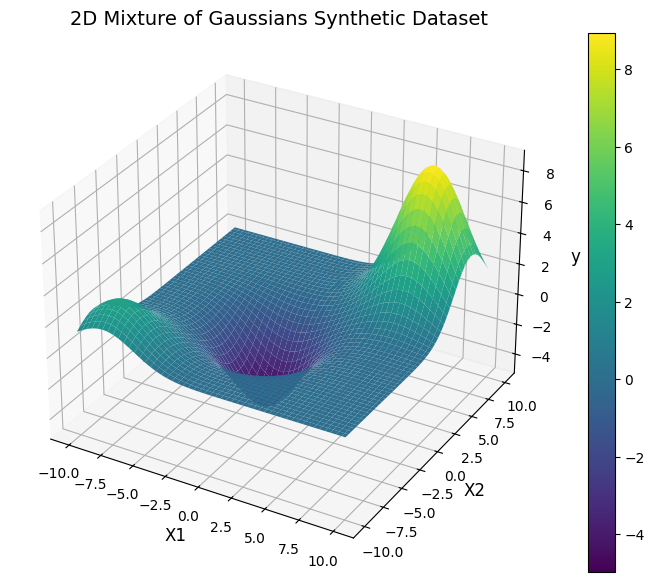

In [ ]:
# Generate training and test data
Ntrain = 150*150  # 22500 points (150x150 grid)
Ntest = 2500      # 2500 points (50x50 grid)

Xtrain, ytrain, XX1_train, XX2_train, YY_train = mog2D_gen(Ntrain, True)
Xtest, ytest, XX1_test, XX2_test, YY_test = mog2D_gen(Ntest, False)

# Shuffle training data
shuffled_ind = np.random.permutation(Xtrain.shape[0])
Xtrain = Xtrain[shuffled_ind, :]
ytrain = ytrain[shuffled_ind]

### Model Configuration

In [ ]:
# Initialize model parameters
model = {
    'n_output': 1,                  # Single output regression
    'n_features': 2,                # 2D input
    'n_hidden': 50,                 # Number of RBF centers
    'epsilon': 0.1,                 # RBF width parameter
    'centres_generation_method': 'clustering'  # Center initialization method
}

### Model Training

In [ ]:
# Train the RBF network
model, W1, W2 = RBF_train_offline(Xtrain, ytrain, model)


### Prediction and Evaluation

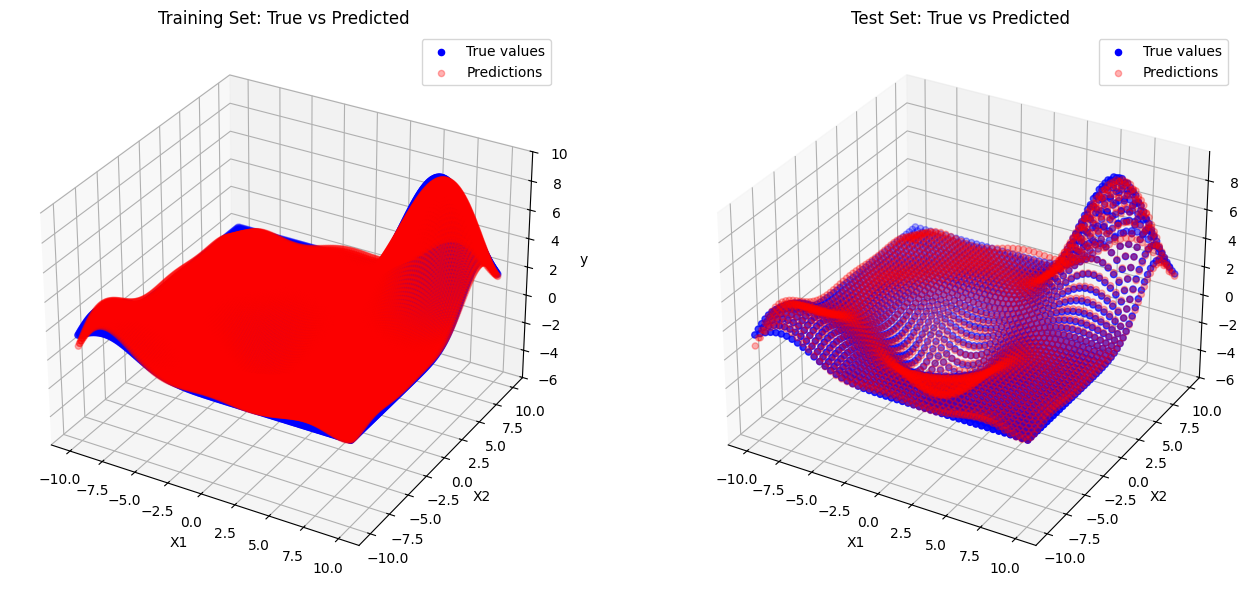

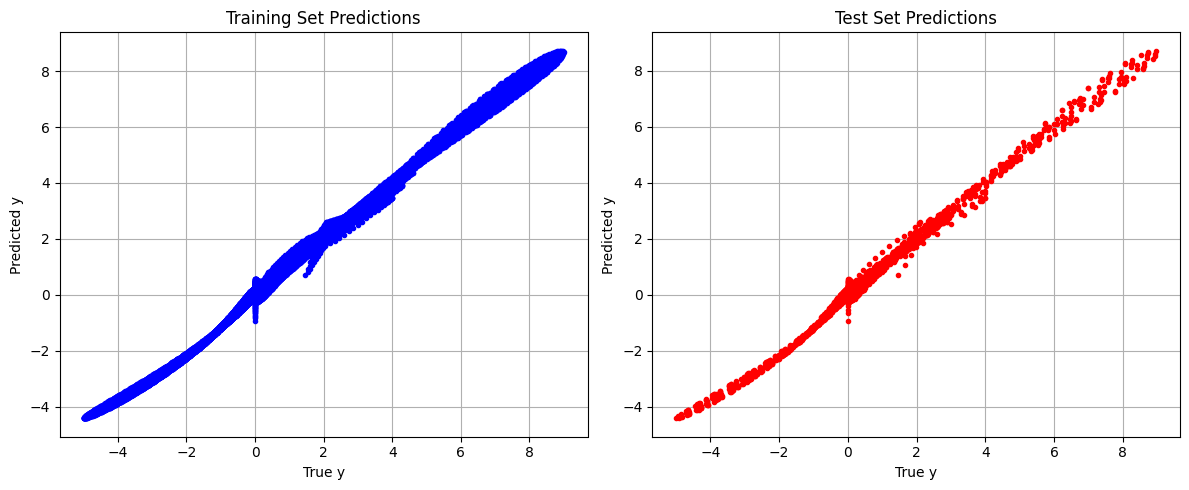

In [ ]:
# Make predictions
ytrain_pred = RBF_predict(Xtrain, W1, W2, model['epsilon'])
ytest_pred = RBF_predict(Xtest, W1, W2, model['epsilon'])

# Reshape predictions to match ytrain/ytest shapes
ytrain_pred = ytrain_pred.ravel()  # Flatten to (22500,)
ytest_pred = ytest_pred.ravel()    # Flatten to (2500,)

# Visualize results - Training set
fig = plt.figure(figsize=(14, 6))

# Training set predictions
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(Xtrain[:, 0], Xtrain[:, 1], ytrain, c='b', label='True values')
ax1.scatter(Xtrain[:, 0], Xtrain[:, 1], ytrain_pred, c='r', alpha=0.3, label='Predictions')
ax1.set_title('Training Set: True vs Predicted', fontsize=12)
ax1.set_xlabel('X1', fontsize=10)
ax1.set_ylabel('X2', fontsize=10)
ax1.set_zlabel('y', fontsize=10)
ax1.legend()

# Test set predictions
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(Xtest[:, 0], Xtest[:, 1], ytest, c='b', label='True values')
ax2.scatter(Xtest[:, 0], Xtest[:, 1], ytest_pred, c='r', alpha=0.3, label='Predictions')
ax2.set_title('Test Set: True vs Predicted', fontsize=12)
ax2.set_xlabel('X1', fontsize=10)
ax2.set_ylabel('X2', fontsize=10)
ax2.set_zlabel('y', fontsize=10)
ax2.legend()

plt.tight_layout()
plt.show()

# Scatter plots of true vs predicted values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(ytrain, ytrain_pred, '.b')  # Removed .T since we flattened
plt.title('Training Set Predictions', fontsize=12)
plt.xlabel('True y', fontsize=10)
plt.ylabel('Predicted y', fontsize=10)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(ytest, ytest_pred, '.r')    # Removed .T since we flattened
plt.title('Test Set Predictions', fontsize=12)
plt.xlabel('True y', fontsize=10)
plt.ylabel('Predicted y', fontsize=10)
plt.grid(True)

plt.tight_layout()
plt.show()


### Performance Metrics

In [ ]:
# Calculate MSE
mse_train = np.mean((ytrain.T - ytrain_pred)**2)
mse_test = np.mean((ytest.T - ytest_pred)**2)

print(f'Training MSE: {mse_train:.4f}')
print(f'Test MSE: {mse_test:.4f}')

Training MSE: 0.0254
Test MSE: 0.0279
